In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pgzip as gz
import _pickle as pkl

import seaborn as sns

In [3]:
with gz.open('TR_DATA/id_genes.pkl.gz', 'rb') as f:
    gene_id = pkl.load(f)
gene_to_id = { x:i for i,x in enumerate(gene_id) }

with gz.open('TR_DATA/id_peaks.pkl.gz', 'rb') as f:
    atac_id = pkl.load(f)
atac_to_id = { x:i for i,x in enumerate(atac_id)}

In [4]:
gene_gtf = pd.read_csv('mm10.ensGene.gtf', sep='\t', header=None)
gene_gtf[:5]

,0,1,2,3,4,5,6,7,8
0,chr1,ensGene,transcript,3073253,3074322,.,+,.,"gene_id ""ENSMUSG00000102693""; transcript_id ""E..."
1,chr1,ensGene,exon,3073253,3074322,.,+,.,"gene_id ""ENSMUSG00000102693""; transcript_id ""E..."
2,chr1,ensGene,transcript,3102016,3102125,.,+,.,"gene_id ""ENSMUSG00000064842""; transcript_id ""E..."
3,chr1,ensGene,exon,3102016,3102125,.,+,.,"gene_id ""ENSMUSG00000064842""; transcript_id ""E..."
4,chr1,ensGene,transcript,3205901,3216344,.,-,.,"gene_id ""ENSMUSG00000051951""; transcript_id ""E..."


In [5]:
mega_to_gene_pos = dict()

for k, v in gene_gtf.iterrows():
    if v[2]!='transcript':
        continue
    gn = v[8].split('"')[1]
    if gn not in gene_to_id:
        continue
        
    gid = gene_to_id[gn]
    chrom = v[0]
    pos = (v[3] + v[4])//2
    tri = (gid, chrom, pos)
    
    mega_key = pos//1000000
    mk1 = (chrom, mega_key)
    mk2 = (chrom, mega_key+1)
    
    if mk1 not in mega_to_gene_pos:
        mega_to_gene_pos[mk1]=[]
    if mk2 not in mega_to_gene_pos:
        mega_to_gene_pos[mk2]=[]
    
    mega_to_gene_pos[mk1].append(tri)
    mega_to_gene_pos[mk2].append(tri)

In [6]:
atac_to_gene = dict()
atac_to_gene['100k'] = []
atac_to_gene['500k'] = []

for i, x in enumerate(atac_id):
    chrom, pos = x.split(':')
    a_pos = int(pos)
    mega_key = (chrom, (a_pos+500000)//1000000)
    
    gid_set_100k = set()
    gid_set_500k = set()
    
    if mega_key not in mega_to_gene_pos:
        continue
        
    for gid, chrom, g_pos in mega_to_gene_pos[mega_key]:
        dist = abs(a_pos - g_pos)
        if dist<500000:
            gid_set_500k.add(gid)
            if dist<100000:
                gid_set_100k.add(gid)
                
    atac_to_gene['100k'].append(sorted(list(gid_set_100k)) )
    atac_to_gene['500k'].append(sorted(list(gid_set_500k)) )

In [7]:
peak_np = dict()
peak_np['ori'] = np.array(pd.read_csv('OUTPUT/peak_nucl.tsv', sep='\t', header=None))

In [8]:
peak_pred_dup = np.array(pd.read_csv('OUTPUT/pred_score_nucl.tsv', sep='\t', header=None))
L = peak_pred_dup.shape[0]//2
peak_pred = (peak_pred_dup[:L] + peak_pred_dup[L:])/2

peak_np['.50'] = np.maximum((peak_pred>0.5)  * 1.0, peak_np['ori'])
peak_np['.45'] = np.maximum((peak_pred>0.45) * 1.0, peak_np['ori'])
peak_np['.55'] = np.maximum((peak_pred>0.55) * 1.0, peak_np['ori'])

In [9]:
peak_total = dict()
for i, a2g in atac_to_gene.items():
    pt = np.zeros((len(gene_id),1))
    for gids in a2g:
        pt[gids,0]+=1
    peak_total[i] = pt

In [10]:
with gz.open('TR_DATA/data_X2.pkl.gz', 'rb') as f:
    gene_exp = pkl.load(f)

In [11]:
gene_act = dict()

In [12]:
for i, pn in peak_np.items():
    for j, a2g in atac_to_gene.items():
        np_new = np.zeros_like(gene_exp)
        for peak1, gids in zip(pn, a2g):
            np_new[gids,:]+=peak1
    
        np_new/=(peak_total[j]+0.000001)
        gene_act[(i, j)]=np_new

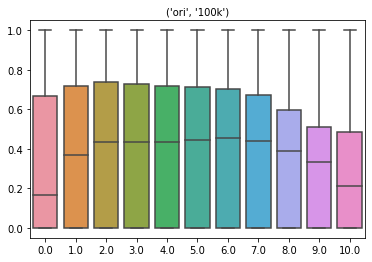

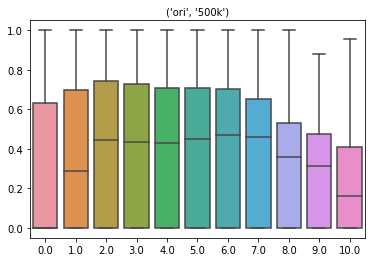

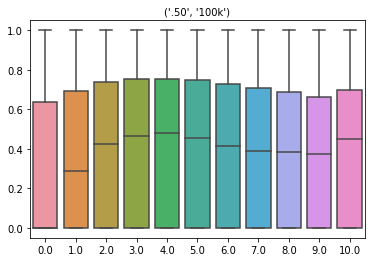

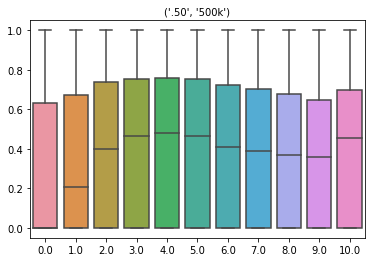

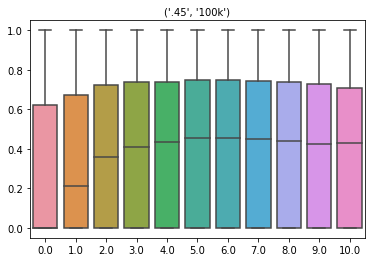

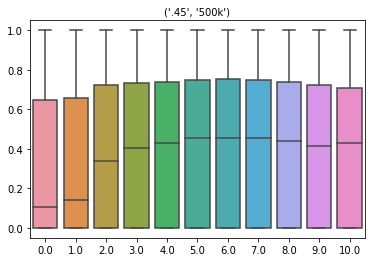

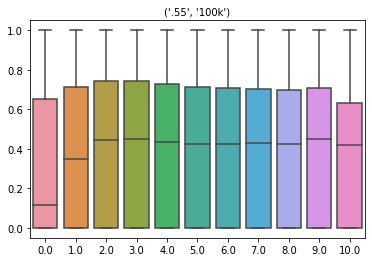

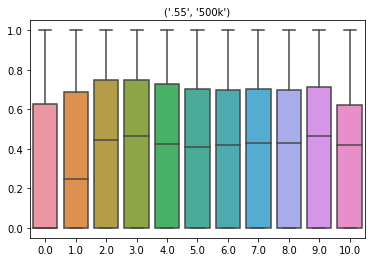

In [13]:
gene_exp_box = gene_exp.flatten()

for k, ga in gene_act.items():
    gas = (ga.flatten()*100+5)//10
    sns.boxplot(x=gas, y=gene_exp_box)
    plt.title(k, size=10)
    plt.show()

In [14]:
peak_np = dict()
peak_np['ori'] = np.array(pd.read_csv('OUTPUT/peak_methyl.tsv', sep='\t', header=None))

In [15]:
peak_pred_dup = np.array(pd.read_csv('OUTPUT/pred_score_methyl.tsv', sep='\t', header=None))
L = peak_pred_dup.shape[0]//2
peak_pred = (peak_pred_dup[:L] + peak_pred_dup[L:])/2

peak_np['.50'] = np.maximum((peak_pred>0.5)  * 1.0, peak_np['ori'])
peak_np['.45'] = np.maximum((peak_pred>0.45) * 1.0, peak_np['ori'])
peak_np['.55'] = np.maximum((peak_pred>0.55) * 1.0, peak_np['ori'])

In [16]:
peak_total = dict()
for i, a2g in atac_to_gene.items():
    pt = np.zeros((len(gene_id),1))
    for gids in a2g:
        pt[gids,0]+=1
    peak_total[i] = pt

In [17]:
with gz.open('TR_DATA/data_X2.pkl.gz', 'rb') as f:
    gene_exp = pkl.load(f)

In [18]:
gene_act = dict()

In [19]:
for i, pn in peak_np.items():
    for j, a2g in atac_to_gene.items():
        np_new = np.zeros_like(gene_exp)
        for peak1, gids in zip(pn, a2g):
            np_new[gids,:]+=peak1
    
        np_new/=(peak_total[j]+0.000001)
        gene_act[(i, j)]=np_new

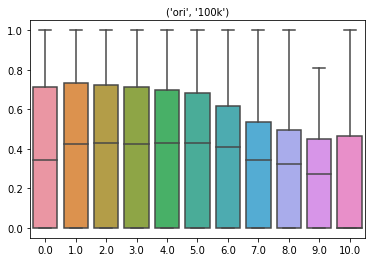

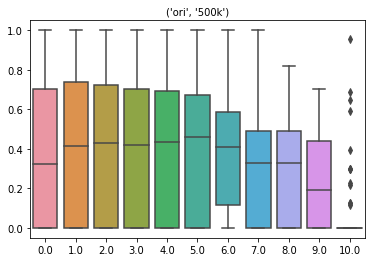

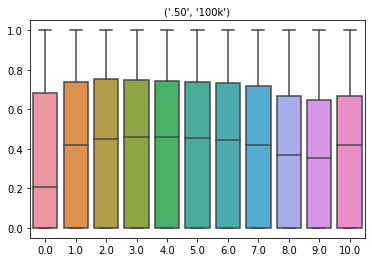

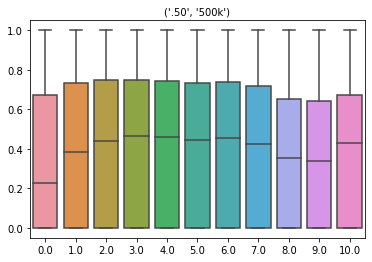

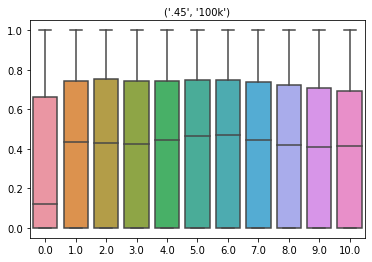

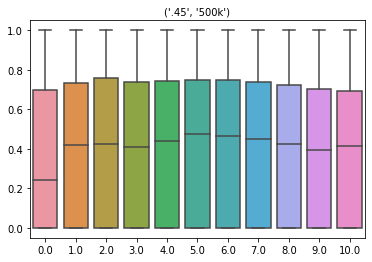

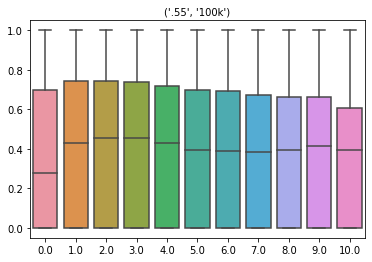

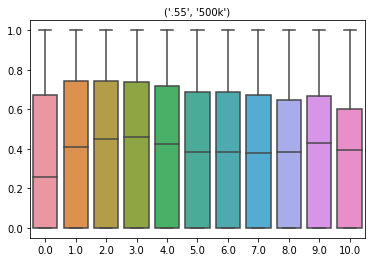

In [20]:
gene_exp_box = gene_exp.flatten()

for k, ga in gene_act.items():
    gas = (ga.flatten()*100+5)//10
    sns.boxplot(x=gas, y=gene_exp_box)
    plt.title(k, size=10)
    plt.show()

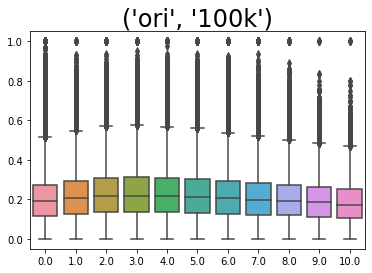

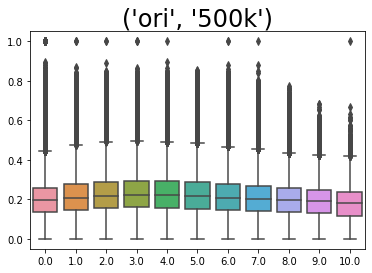

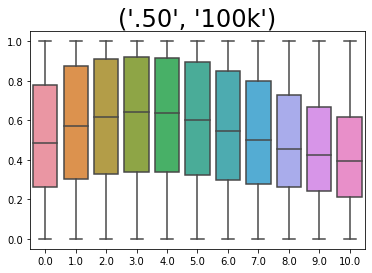

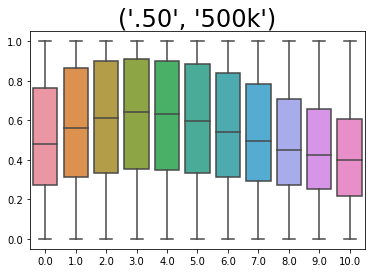

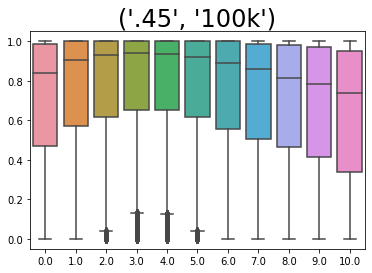

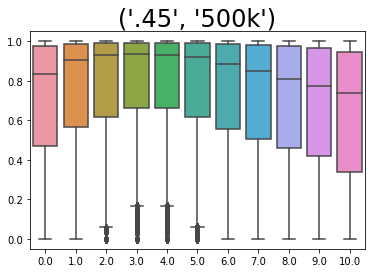

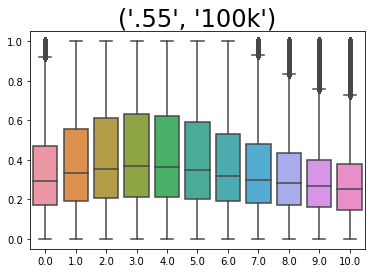

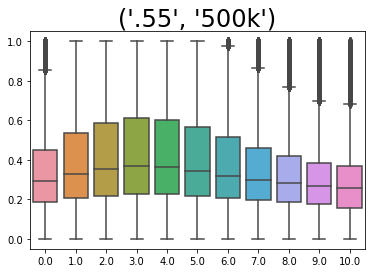

In [21]:
gene_exp_box = (gene_exp.flatten()*100+5)//10

for k, ga in gene_act.items():
    sns.boxplot(x=gene_exp_box, y=ga.flatten())
    plt.title(k, size=24)
    plt.show()

In [22]:
error(error)

NameError: name 'error' is not defined

In [ ]:
gene_ori = np.zeros((peak_ori.shape[0],1))

In [ ]:
gene_to_pos = dict()
meg_to_gene = dict()

for x in gene_table.iterrows():
    chrom, pos1, pos2, gn = list(x[1])
    if gn not in gene_to_id:
        continue
    pos = (pos1+pos2)//2
    
    gid = gene_to_id[gn]
    gene_to_pos[gn] = [chrom, pos, gid ]
    
    meg1 = pos//1000000
    key1 = (chrom, meg1)
    if key1 not in meg_to_gene:
        meg_to_gene[key1] = []
    meg_to_gene[key1].append(gn)
    key2 = (chrom, meg1+1)
    if key2 not in meg_to_gene:
        meg_to_gene[key2] = []
    meg_to_gene[key2].append(gn)    

In [ ]:
atac_to_gene_10k = [[]] * len(atac_id)
atac_to_gene_50k = [[]] * len(atac_id)
gene_to_atac_50k = [[]] * len(gene_id)
gene_to_atac_10k = [[]] * len(gene_id)

In [ ]:
for i, x in enumerate(atac_id):
    
    chrom, pos = x.split(':')
    pos = int(pos)
    meg1 = (pos + 500000)//1000000
    key1 = (chrom, meg1)
    if key1 not in meg_to_gene:
        continue
        
    for gn in meg_to_gene[key1]:
        
        g_chr, g_pos, g_id = gene_to_pos[gn]
        if abs(pos - g_pos) < 500000:
            atac_to_gene_50k[i].append(g_id)
            gene_to_atac_50k[g_id].append(i)
            
            if abs(pos - g_pos) < 100000:
                atac_to_gene_10k[i].append(g_id)
                gene_to_atac_10k[g_id].append(i)

In [ ]:
meg_to_gene

In [ ]:
gene_to_atac_10k

In [ ]:
pd.read_csv('TR_DATA/id_peaks.pkl.gz')

In [ ]:
gene_gtf_tr[8].apply( lambda x: x.split(';')[0].split(' ')[1] )

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

%matplotlib inline

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [ ]:
def recalculate_fpr_tpr(fpr, tpr, totalT, totalF, percent):
    hT = totalF * percent/100 #hidden true
    
    T_re = totalT + hT
    F_re = totalF - hT
    
    hTp = tpr * hT
    Fp = fpr * totalF
    Fp_re = Fp - hTp
    fpr_re = Fp_re / F_re
        
    args = np.argsort(fpr_re)
    fpr_re_s = fpr_re[args]
    tpr_re_s = tpr[args]
    mask = (fpr_re_s>=0)
    
    return fpr_re_s[mask], tpr_re_s[mask]
    

In [ ]:
def getTestPred(Y_true, Y_pred):
    N = len(Y_true)
    y_test = np.array(Y_true).flatten()

    y_score_2x = np.array(Y_pred)
    y_score = ((y_score_2x[:N,:] + y_score_2x[N:,:]) / 2).flatten()

    totalT = np.sum(y_test)
    totalF = y_test.shape[0] - totalT
    
    return y_test, y_score, totalT, totalF



In [ ]:
def getFprTprAuc(y_test, y_score, totalT, totalF):
    
    fpr, tpr, roc_auc = [0]*5, [0]*5, [0]*5

    fpr[0], tpr[0], _ = roc_curve(y_test, y_score)
    roc_auc[0] = auc(fpr[0], tpr[0])

    for x in range(1,5):
        fpr[x], tpr[x] = recalculate_fpr_tpr(fpr[0], tpr[0], totalT, totalF, x*10 )
        roc_auc[x] = auc(fpr[x], tpr[x])
        
    return fpr, tpr, roc_auc

In [ ]:
def drawAUC(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    #cmap_a = ['grey','b','g','orange','r']
    cmap_a = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']

    plt.axis('square')
    for x in range(len(fpr)):
        plt.plot(fpr[x], tpr[x], c=cmap_a[x],
             lw=lw, label='%d%% (AUC = %0.2f)' % (x*10, roc_auc[x]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def drawPicFromData(Y_TRUE, NP_PRED):
    y_test, y_score, totalT, totalF = getTestPred(Y_TRUE, NP_PRED)
    print('T=', totalT, 'F=', totalF)
    fpr, tpr, roc_auc = getFprTprAuc(y_test, y_score, totalT, totalF)
    drawAUC(fpr, tpr, roc_auc)

In [ ]:
def prec_recall(Y_TRUE, NP_PRED):
    y_test, y_score, totalT, totalF = getTestPred(Y_TRUE, NP_PRED)
    precision, recall, thresholds = precision_recall_curve( y_test, y_score)
    
    F1 = 2*(recall * precision) / (recall + precision)
    F2 = 5*(recall * precision) / (recall + 4*precision)

    plt.figure()
    lw = 2
    #cmap_a = ['grey','b','g','orange','r']
    cmap_a = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']

    plt.axis('square')
    plt.plot(thresholds, precision[:-1], c=cmap_a[0], lw=lw, label='precision')
    plt.plot(thresholds, recall[:-1],    c=cmap_a[1], lw=lw, label='recall')
    plt.plot(thresholds, F1[:-1],        c=cmap_a[2], lw=lw, label='F1')
    plt.plot(thresholds, F2[:-1],        c=cmap_a[3], lw=lw, label='F2')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Threshold')
    plt.ylabel('')
    plt.title('Prec/Recall')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
NP_Nucl = pd.read_csv('OUTPUT/pred_score_nucl.tsv', sep='\t', header=None)
NP_Methyl = pd.read_csv('OUTPUT/pred_score_methyl.tsv', sep='\t', header=None)

Y_Nucl = pd.read_csv('OUTPUT/peak_nucl.tsv', sep='\t', header=None)
Y_Methyl = pd.read_csv('OUTPUT/peak_methyl.tsv', sep='\t', header=None)

In [ ]:
NP_Nucl_c = pd.read_csv('OUTPUT/pred_c0_score_nucl.tsv', sep='\t', header=None)
NP_Methyl_c = pd.read_csv('OUTPUT/pred_c1_score_met.tsv', sep='\t', header=None)

Y_Nucl_c = pd.read_csv('OUTPUT/peak_c0_nucl.tsv', sep='\t', header=None)
Y_Methyl_c = pd.read_csv('OUTPUT/peak_c1_met.tsv', sep='\t', header=None)

In [ ]:
Y_Nucl.shape

In [ ]:
y_test, y_score, totalT, totalF = getTestPred(Y_Nucl, NP_Nucl)
print('T=', totalT, 'F=', totalF)
fpr, tpr, roc_auc = getFprTprAuc(y_test, y_score, totalT, totalF)
drawAUC(fpr[:1], tpr[:1], roc_auc[:1])

In [ ]:
y_test_c, y_score_c, totalT_c, totalF_c = getTestPred(Y_Nucl_c, NP_Nucl_c)
print('Tc=', totalT_c, 'Fc=', totalF_c)
fpr_c, tpr_c, roc_auc_c = getFprTprAuc(y_test_c, y_score_c, totalT_c, totalF_c)
drawAUC(fpr_c[:1], tpr_c[:1], roc_auc_c[:1])

In [ ]:
y_test, y_score, totalT, totalF = getTestPred(Y_Methyl, NP_Methyl)
print('T=', totalT, 'F=', totalF)
fpr, tpr, roc_auc = getFprTprAuc(y_test, y_score, totalT, totalF)
drawAUC(fpr[:1], tpr[:1], roc_auc[:1])

In [ ]:
y_test, y_score, totalT, totalF = getTestPred(Y_Methyl_c, NP_Methyl_c)
print('T=', totalT, 'F=', totalF)
fpr, tpr, roc_auc = getFprTprAuc(y_test, y_score, totalT, totalF)
drawAUC(fpr[:1], tpr[:1], roc_auc[:1])

In [ ]:
drawPicFromData(Y_Nucl, NP_Nucl)

In [ ]:
drawPicFromData(Y_Methyl, NP_Methyl)

In [ ]:
drawPicFromData(Y_Nucl_c, NP_Nucl_c)

In [ ]:
drawPicFromData(Y_Methyl_c, NP_Methyl_c)

In [ ]:
prec_recall(Y_Nucl, NP_Nucl)

In [ ]:
prec_recall(Y_Methyl, NP_Methyl)

In [ ]:
prec_recall(Y_Nucl_c, NP_Nucl_c)

In [ ]:
prec_recall(Y_Methyl_c, NP_Methyl_c)

In [ ]:
NP_Nucl_10pct = pd.read_csv('OUTPUT/pred_score_nucl_10pct.tsv', sep='\t', header=None)
NP_Methyl_10pct = pd.read_csv('OUTPUT/pred_score_methyl_10pct.tsv', sep='\t', header=None)

Y_Nucl_10pct = pd.read_csv('OUTPUT/peak_nucl_10pct.tsv', sep='\t', header=None)
Y_Methyl_10pct = pd.read_csv('OUTPUT/peak_methyl_10pct.tsv', sep='\t', header=None)

In [ ]:
drawPicFromData(Y_Nucl_10pct, NP_Nucl_10pct)

In [ ]:
drawPicFromData(Y_Methyl_10pct, NP_Methyl_10pct)

In [ ]:
drawPicFromData(Y_Nucl, NP_Nucl_10pct)

In [ ]:
drawPicFromData(Y_Methyl, NP_Methyl_10pct)

In [ ]:
prec_recall(Y_Nucl_10pct, NP_Nucl_10pct)

In [ ]:
prec_recall(Y_Methyl_10pct, NP_Methyl_10pct)

In [ ]:
prec_recall(Y_Nucl, NP_Nucl_10pct)

In [ ]:
prec_recall(Y_Methyl, NP_Methyl_10pct)

In [ ]:
NP_Nucl_20pct = pd.read_csv('OUTPUT/pred_score_nucl_20pct.tsv', sep='\t', header=None)
NP_Methyl_20pct = pd.read_csv('OUTPUT/pred_score_methyl_20pct.tsv', sep='\t', header=None)

Y_Nucl_20pct = pd.read_csv('OUTPUT/peak_nucl_20pct.tsv', sep='\t', header=None)
Y_Methyl_20pct = pd.read_csv('OUTPUT/peak_methyl_20pct.tsv', sep='\t', header=None)

In [ ]:
drawPicFromData(Y_Nucl_20pct, NP_Nucl_20pct)

In [ ]:
drawPicFromData(Y_Methyl_20pct, NP_Methyl_20pct)

In [ ]:
drawPicFromData(Y_Nucl, NP_Nucl_20pct)

In [ ]:
drawPicFromData(Y_Methyl, NP_Methyl_20pct)

In [ ]:
prec_recall(Y_Nucl_20pct, NP_Nucl_20pct)

In [ ]:
prec_recall(Y_Methyl_20pct, NP_Methyl_20pct)

In [ ]:
prec_recall(Y_Nucl, NP_Nucl_20pct)

In [ ]:
prec_recall(Y_Methyl, NP_Methyl_20pct)

In [ ]:
def draw_trainig_curve(fn):
    with gz.open(fn, 'rb') as f:
        (epoch0_loss, l_loss) = pkl.load(f)

    L = len(epoch0_loss)
    np_L = np.expand_dims(np.array(range(1, L+1))/(L+1), axis=1)
    np_epoch = np.array(epoch0_loss)
    np_mean = np_epoch.mean(axis=1, keepdims=True)
    np_epoch0 = np.concatenate([np_L, np_epoch, np_mean], axis=1)

    L = len(l_loss)
    np_L = np.expand_dims(np.array(range(1, L+1)), axis=1)
    np_epoch = np.array(l_loss)
    np_mean = np_epoch.mean(axis=1, keepdims=True)
    np_epoch1 = np.concatenate([np_L, np_epoch, np_mean], axis=1)

    pd_loss = pd.DataFrame( np.concatenate([np_epoch0,np_epoch1], axis=0) )

    sns.lineplot(x=0, y=1, data=pd_loss)
    sns.lineplot(x=0, y=2, data=pd_loss)
    sns.lineplot(x=0, y=3, data=pd_loss)
    plt.xscale('log')

In [ ]:
draw_trainig_curve('OUTPUT/loss_dup.pkl.gz')

In [ ]:
draw_trainig_curve('OUTPUT/loss_.pkl.gz')